In [1]:
import pickle
import os
import sys

# include parent directory in path
parent_dir = os.path.abspath('../..')
sys.path.append(parent_dir)

if os.path.exists('clients.pkl'):
    with open('clients.pkl', 'rb') as file:
        clients = pickle.load(file)
else:
    print('No clients found')


In [14]:
# imports
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import pandas as pd


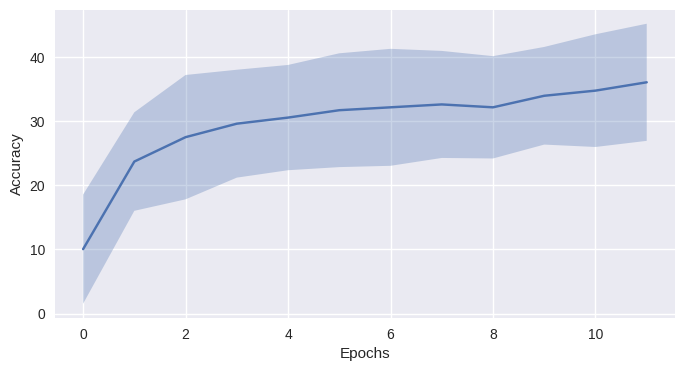

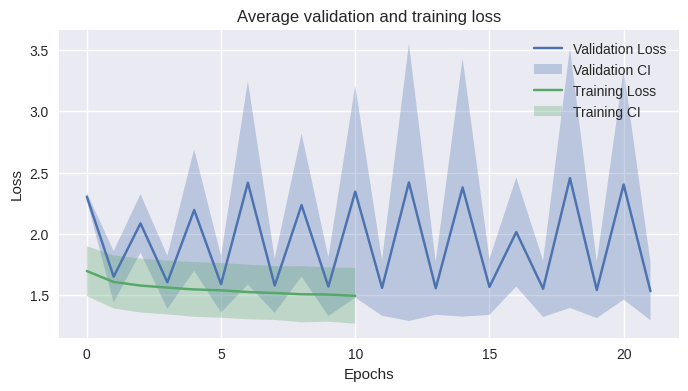

In [13]:
plt.figure(figsize=(8, 4))
avg_acc = np.mean([client.val_acc_list for client in clients], axis=0)
std_acc = np.std([client.val_acc_list for client in clients], axis=0)
plt.plot(avg_acc)
plt.fill_between(range(len(avg_acc)), avg_acc - std_acc, avg_acc + std_acc, alpha=0.3)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.figure(figsize=(8, 4))
avg_val_loss = np.mean([client.val_loss_list for client in clients], axis=0)
std_val_loss = np.std([client.val_loss_list for client in clients], axis=0)
plt.plot(avg_val_loss)
plt.fill_between(range(len(avg_val_loss)), avg_val_loss - std_val_loss, avg_val_loss + std_val_loss, alpha=0.3)
plt.xlabel('Epochs')
plt.ylabel('Loss')

avg_train_loss = np.mean([client.train_loss_list for client in clients], axis=0)
std_train_loss = np.std([client.train_loss_list for client in clients], axis=0)
plt.plot(avg_train_loss)
plt.fill_between(range(len(avg_train_loss)), avg_train_loss - std_train_loss, avg_train_loss + std_train_loss, alpha=0.3)
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.title('Average validation and training loss')
plt.legend(['Validation Loss', 'Validation CI', 'Training Loss', 'Training CI'])
plt.show()